# Previsão de popularidade de uma Música

* Filipa Periquito a22206373
* Jorge Leitão a22210044
* Sérgio Assunção a22206576

# Introdução

A música faz parte do nosso dia-a-dia. Ouvimos música na rádio, na televisão e cada vez mais em serviços de *streaming*. A música é uma arte e, como tal, subjetiva. No entanto, podemos afirmar que existem músicas mais populares que outras, que nos cativam e ouvimos repetidamente e outras que nem ouvimos. Então, quais são as características de uma música que a fazem popular? A previsão da popularidade de uma música é um problema complexo, cuja resposta é valiosa para compositores, músicos e produtoras cujo retorno financeiro está diretamente relacionado com a popularidade das suas músicas. Assim, o objetivo deste trabalho é a construção de um modelo que permita prever a popularidade de uma música.

# Metodologia
Um dos serviços de *streaming* mais utilizados a nível mundial é o *Spotify*. Esta plataforma disponibiliza todos os dados e metadados das músicas disponibilizadas, através da [Web API][1] do *Spotify*. <p> Para este trabalho utilizou-se o conjunto de dados [Song Popularity Dataset][2] da comunidade [Kaggle][3].
As variáveis em estudo e respetiva descrição encontram-se seguidamente identificadas:
* **Name:** Variável Categórica (*string*) que identifica o nome da música.
* **Acousticness:** Variável numérica (*float*). Uma medida de confiança entre 0,0 e 1,0 que procura identificar se uma música é acústica, isto é, se uma música é gerada sem qualquer amplificação eletrónica. 
* **Danceability:** Variável numérica (*float*). Descreve se uma música é adequada para dançar com base numa combinação de elementos musicais, incluindo o tempo, ritmo, a força do batimento e a regularidade geral. Um valor de 0,0 significa que a música é menos “dançável” e o valor de 1,0 é mais “dançável”.
* **Duration** Variável numérica (*integer*). Representa a duração da música em milisegundos (ms).
* **Energy:** Variável numérica (*float*). Representa uma medida de intensidade e atividade. As músicas com elevados índices de energia são percecionadas como rápidas e ruidosas. Esta variável varia entre 0,0 e 1,0.
* **Instrumentalness:** Variável numérica (*float*). Identifica a ausência de voz numa música, ou seja, quanto mais próximo o valor de “instrumentalidade” for de 1,0, maior a probabilidade de uma música não conter conteúdo vocal.
* **Key:** Variável numérica (*integer*). Esta variável identifica a tonalidade de uma música, isto é, cada número inteiro representa uma nota musical (*0=C, 1=C#/Db, 2=D,..*).
* **Liveness:** Variável numérica (*float*). Deteta se uma música foi tocada ao vivo, valores mais elevados de *liveness* representam uma probabilidade maior de que uma música tenha sido tocada com a presença de público.
* **Loudness:** Variável numérica(*float*). Corresponde ao volume relativo de uma música em decibéis (dB). 
* **Mode:** Variável numérica (*integer*). Indica a modo (maior ou menor) de uma música, onde o tom maior é representado por 1 e o menor por 0.
* **Speechiness:** Variável numérica (*float*). É uma medida da presença de palavras (faladas/cantadas por pessoas) numa música. Varia entre 0 e 1, onde uma música instrumental tem o valor de 0.
* **Tempo:** Variável numérica (*float*) . O ritmo estimado de uma música em batimentos por minuto (BPM). O tempo é a velocidade ou o ritmo de uma determinada peça musical.
* **Time Signature:** Variável numérica (*integer*). Representa o número de batimentos que existem em cada compasso.
* **Valence:** Variável numérica (*integer*). É uma medida de 0,0 a 1,0 que descreve a positividade musical transmitida numa música. Músicas com valores mais elevados estão associados a sentimentos de felicidade e alegria, enquanto que as músicas com valores mais baixos poderão apresentar maiores índices de tristeza e melancolia.
* **Song Popularity:** Variável numérica (*integer*) que assume valores entre 0 e 100, em que 100 é a mais popular. A popularidade é calculada a partir do número de vezes que a música é tocada e quão recentemente foi tocada. 

Para este trabalho considerou-se como variável-alvo o atributo *Song_popularity*, sendo os restantes atributos considerados variáveis independentes.


* ### Criação de SparkSession e importação das bibliotecas necessárias

In [1]:
# Import PySpark and create a SparkSession
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ImportData").getOrCreate()

Utilizaram-se as bibliotecas *Pandas, Seaborn e MatPlotLib* para permitir a visualização de dados, nomeadamente distribuição de variáveis, matriz de correlações, curva ROC e matriz confusão. Para calcular a curva ROC e a matriz confusão recorreu-se ao *SKLearn*. Para implementação dos algoritmos utilizou-se o [*PySpark*][4].<p> O *PySpark* é uma interface que permite escrever aplicações *Spark* usando APIs *Python*. Utilizaram-se as seguintes bibliotecas do *PySpark*:
* *Spark SQL* para processamento de dados estruturados, nomeadamente *DataFrames*;
* *MLLib* para implementação, avaliação e ajuste dos modelos de Aprendizagem Automática.

In [2]:
# Import Pandas, Seaborn, MatPlotlib, SKLearn, Pyspark SQL e ML
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import when, col
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

* ### Criação de DataFrame com o conjunto de dados

In [3]:
# Importar os dataset de acordo com o tipo de dados
schema = StructType([StructField("song_name", StringType(), True),
                    StructField("song_popularity", IntegerType(), True),
                    StructField("song_duration_ms", IntegerType(), True),
                    StructField("acousticness", FloatType(), True),
                    StructField("danceability", FloatType(), True),
                    StructField("energy", FloatType(), True),
                    StructField("instrumentalness", FloatType(), True),
                    StructField("key", IntegerType(), True),
                    StructField("liveness", FloatType(), True),
                    StructField("loudness", FloatType(), True),
                    StructField("audio_mode", IntegerType(), True),
                    StructField("speechiness", FloatType(), True),
                    StructField("tempo", FloatType(), True),
                    StructField("time_signature", IntegerType(), True),
                    StructField("audio_valence", FloatType(), True)])


df_songs=spark.read.option("header","true").csv('song_data.csv',schema=schema)

* ### Limpeza dos dados

Nesta fase removem-se os registos que não são úteis e que podem condicionar os resultados, eliminando-se 5765 registos duplicados e 1 NULL.

In [4]:
#Remoção de Nulos e Duplicados
print(df_songs.count(),"registos lidos")

df_songs=df_songs.na.drop()
df_songs=df_songs.drop_duplicates(['song_name'])

print(df_songs.count(), "registos após limpeza dos dados")

18835 registos lidos
13069 registos após limpeza dos dados


* ### Análise Exploratória dos dados

In [5]:
# Visualização dos dados 
df_songs.show(10)

+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|           song_name|song_popularity|song_duration_ms|acousticness|danceability|energy|instrumentalness|key|liveness|loudness|audio_mode|speechiness|  tempo|time_signature|audio_valence|
+--------------------+---------------+----------------+------------+------------+------+----------------+---+--------+--------+----------+-----------+-------+--------------+-------------+
|              Remedy|             70|          207213|      1.8E-4|       0.546| 0.959|         0.00144|  8|  0.0584|  -4.664|         1|      0.082|127.831|             4|        0.416|
|        La Gota Fría|             66|          215493|      0.0893|       0.719| 0.809|             0.0|  1|   0.183| -10.201|         1|     0.0511|100.839|             4|        0.964|
|   Magic Carpet Ride|             68|          271573|     

In [6]:
# Estatísticas sumárias
df_songs.describe().show()

+-------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|summary|           song_name|   song_popularity|  song_duration_ms|      acousticness|       danceability|            energy|   instrumentalness|               key|           liveness|          loudness|        audio_mode|        speechiness|             tempo|    time_signature|      audio_valence|
+-------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|  count|               13069|             13069|             13069|             13069|       

A variável-alvo (*song_popularity*) apresenta uma distribuição aparentemente normal, conforme é visualizável no *plot* seguinte:

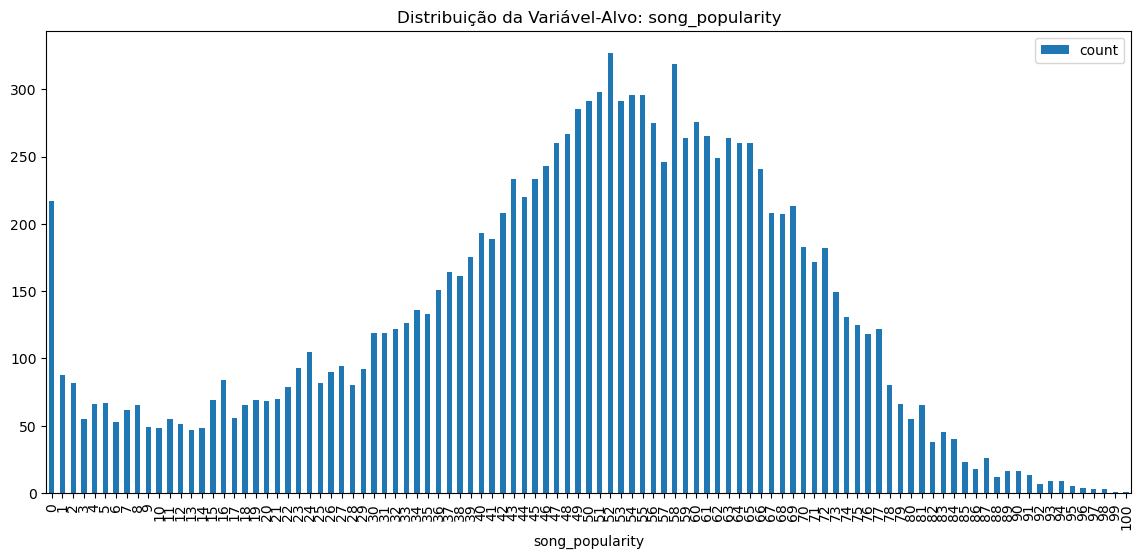

In [7]:
# Distribuição da variável target 'song_popularity'
distrib_Popularity = df_songs.groupBy("song_popularity").count().sort("song_popularity", ascending=True)
distrib_Popularity.toPandas().plot.bar(x='song_popularity',figsize=(14,6))
plt.title("Distribuição da Variável-Alvo: song_popularity")
plt.show()

In [8]:
# Preparação da matriz Correlações
df_songsAux = df_songs.drop('song_name')
assemblerCorr = VectorAssembler(inputCols = df_songsAux.columns, outputCol = "features_corr")
df_vector = assemblerCorr.transform(df_songsAux).select("features_corr")

matriz_Corr = Correlation.corr(df_vector, "features_corr",'pearson')
lista_Corr = matriz_Corr.collect()[0][0].toArray().tolist()

c:\Users\jojav\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


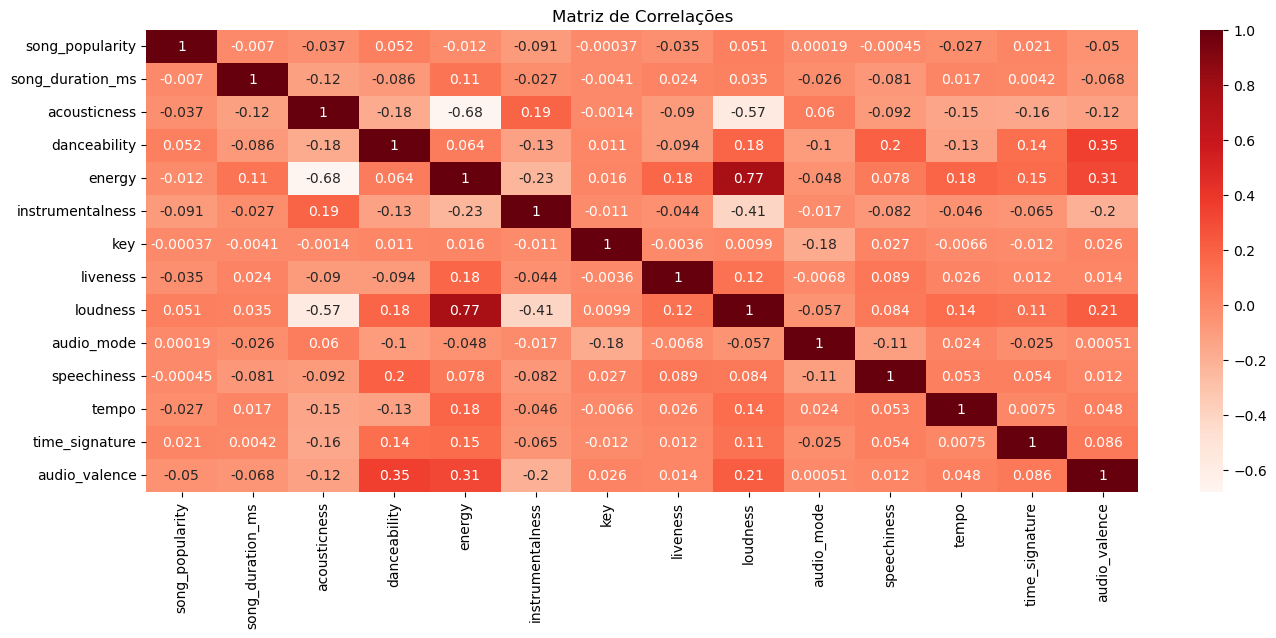

In [9]:
# Conversão para DataFrame do Pandas e visualizaçãop da matriz de correlações
matrizCorr_pd = pd.DataFrame(data=lista_Corr, columns = df_songsAux.columns, index=df_songsAux.columns) 
plt.figure(figsize=(16,6))  
sns.heatmap(matrizCorr_pd, xticklabels=matrizCorr_pd.columns,yticklabels=matrizCorr_pd.columns,  cmap="Reds", annot=True)
plt.title('Matriz de Correlações')
plt.show()

* ### Preparação dos dados para os modelos

In [10]:
# Seleção das features a utilizar nos modelos e criação do Assembler
features_col = ["song_duration_ms", "acousticness","danceability", "energy", "instrumentalness", "key", "liveness", "loudness", "audio_mode", "speechiness", "tempo", "time_signature", "audio_valence"]
# criar o VectorAssembler para juntar as features numa coluna
assemblerModel = VectorAssembler(inputCols = features_col, outputCol= "features")

* ### Implementação do Algoritmo de Regressão Linear

Uma vez que os atributos (*features*) do conjunto de dados utilizado apresentam valores com escalas diferentes, os dados foram standardizados. Desta forma, previne-se que atributos com variâncias maiores tenham mais influência no treino do modelo.

In [11]:
# Standardizar dados
data_lr = assemblerModel.transform(df_songs).select("features", "song_popularity")

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)
data_lr = standardScaler.fit(data_lr).transform(data_lr)
data_lr.show(5)

+--------------------+---------------+--------------------+
|            features|song_popularity|     features_scaled|
+--------------------+---------------+--------------------+
|[207213.0,1.80000...|             70|[-0.1799098998804...|
|[215493.0,0.08929...|             66|[-0.0494191913737...|
|[271573.0,0.14200...|             68|[0.83438744305320...|
|[227705.0,0.85600...|             67|[0.14303884392621...|
|[232466.0,1.99000...|             53|[0.21807100131755...|
+--------------------+---------------+--------------------+
only showing top 5 rows



In [12]:
# Dividir em conjunto de treino e Teste
train, test = data_lr.randomSplit([0.7, 0.3],seed=152)

In [13]:
# Modelo Regressão Linear
lr = (LinearRegression(featuresCol='features_scaled',\
                       labelCol="song_popularity",\
                        predictionCol='song_pop_pred_lr',\
                        maxIter=20,\
                        elasticNetParam=0,\
                        standardization=True,\
                       ))
linearModel = lr.fit(train)

In [14]:
# Previsões
predlr = linearModel.transform(test)
predictions_lr = predlr.select("song_pop_pred_lr", "song_popularity")
predictions_lr.show(10)

+-----------------+---------------+
| song_pop_pred_lr|song_popularity|
+-----------------+---------------+
|40.03296719620041|             61|
|44.39552999131088|             58|
|46.46469067240976|             13|
|36.57561550875528|             26|
|47.34509868605489|             16|
|42.86722077501086|             45|
| 36.0461723963856|             58|
|39.19281460405209|             44|
| 45.6460804597956|             46|
|47.45072265380398|             54|
+-----------------+---------------+
only showing top 10 rows



In [15]:
# Métricas
print("Root Mean Squared Error (RMSE): ", linearModel.summary.rootMeanSquaredError)
print("Mean Squared Error (MSE): ", linearModel.summary.meanSquaredError)
print("Mean Absolute Error (MAE): ", linearModel.summary.meanAbsoluteError)
print("R quadrado (R2): ", linearModel.summary.r2)

Root Mean Squared Error (RMSE):  19.928610330866977
Mean Squared Error (MSE):  397.149509719538
Mean Absolute Error (MAE):  15.783549553527566
R quadrado (R2):  0.021323807833322217


* ### Implementação do Algoritmo de Classificação Decision Tree

A implementação de um algoritmo de classificação implica a transformação da variável-alvo em classes. A *song_popularity* foi transformada em valores binários, em que 0 corresponde às músicas consideradas menos populares (variando de 0 a 50) e o valor 1 está associado a valores superiores a 50, ou seja, corresponde às músicas com maior índice de popularidade.

In [16]:
# Converter a coluna "song_popularity" em binário
df_songs_dt = df_songs.withColumn("song_popularity", when(col("song_popularity") > 50, 1).otherwise(0))
df_songs_dt.select("song_popularity").show(5)

+---------------+
|song_popularity|
+---------------+
|              1|
|              1|
|              1|
|              1|
|              1|
+---------------+
only showing top 5 rows



In [17]:
# transformar o DataFrame original usando o VectorAssembler
data_dt = assemblerModel.transform(df_songs_dt).select("features", "song_popularity").withColumnRenamed("song_popularity", "label")
data_dt.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[207213.0,1.80000...|    1|
|[215493.0,0.08929...|    1|
|[271573.0,0.14200...|    1|
|[227705.0,0.85600...|    1|
|[232466.0,1.99000...|    1|
+--------------------+-----+
only showing top 5 rows



In [18]:
# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = data_dt.randomSplit([0.7, 0.3], seed=12345)

In [20]:
# criar o modelo de árvore de decisão
dt = DecisionTreeClassifier(seed=123, labelCol="label", featuresCol="features")

model_dt = dt.fit(train_data)
predictions_dt = model_dt.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator.evaluate(predictions_dt)
print("Accuracy sem Cross Validation:", accuracy_dt)

Accuracy sem Cross Validation: 0.5691879585125221


In [21]:
# Definir o grid de hiperparâmetros para a Cross Valitadion
paramGrid = (ParamGridBuilder()\
            .addGrid(dt.maxDepth, [5, 10, 15])\
            .addGrid(dt.impurity, ["gini", "entropy"])\
            .build())

In [22]:
# Definir o avaliador de desempenho
evaluator_acc = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

In [23]:
# criar o objeto CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=MulticlassClassificationEvaluator(), numFolds=5, seed=123)

In [24]:
# treinar o modelo
model = cv.fit(train_data)

In [25]:
# Fazer previsões nos dados de teste
predictions = model.transform(test_data)
predictions.select('prediction','label').show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 5 rows



In [26]:
# Avaliação do modelo - Accuracy = 57,2%
accuracy = evaluator_acc.evaluate(predictions)
print("Accuracy com Cross Validation:", accuracy)

Accuracy com Cross Validation: 0.5724766000505945


In [29]:
# Obter a árvore de decisão do modelo
tree = model.bestModel

In [30]:
# Obter a estrutura da árvore em formato de texto
tree_structure = tree.toDebugString

In [31]:
# Imprimir a estrutura da árvore de decisão
print(tree.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c1043ff9d84a, depth=5, numNodes=43, numClasses=2, numFeatures=13
  If (feature 4 <= 1.6099999629659578E-4)
   If (feature 1 <= 0.42249999940395355)
    If (feature 7 <= -8.029500007629395)
     If (feature 0 <= 233468.5)
      If (feature 7 <= -10.599500179290771)
       Predict: 0.0
      Else (feature 7 > -10.599500179290771)
       Predict: 1.0
     Else (feature 0 > 233468.5)
      Predict: 1.0
    Else (feature 7 > -8.029500007629395)
     If (feature 3 <= 0.8334999978542328)
      Predict: 1.0
     Else (feature 3 > 0.8334999978542328)
      If (feature 7 <= -6.14300012588501)
       Predict: 0.0
      Else (feature 7 > -6.14300012588501)
       Predict: 1.0
   Else (feature 1 > 0.42249999940395355)
    If (feature 12 <= 0.6745000183582306)
     If (feature 0 <= 186686.0)
      Predict: 0.0
     Else (feature 0 > 186686.0)
      Predict: 1.0
    Else (feature 12 > 0.6745000183582306)
     If (feature 7 <= -7.155500173568

Para melhor compreensão do desempenho do modelo treinado, mostra-se de seguida a curva ROC:

In [32]:
# Calcular a curva ROC
results = predictions.select(['probability', 'label'])

fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[0] for i in results.select('label').collect()]
y_score = [i[0][1] for i in results.select('probability').collect()]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

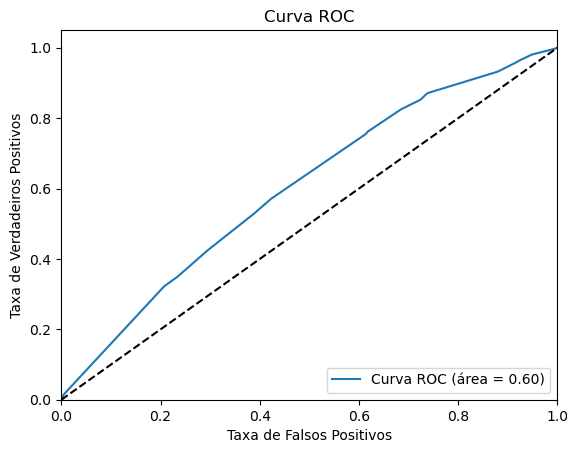

In [33]:
# Plot da curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

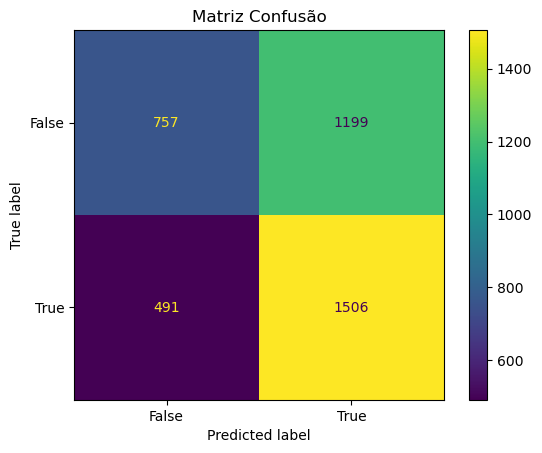

In [34]:
# Calcular a matriz de confusão
actual=predictions.select('label').toPandas().values.reshape(-1)
predicted= predictions.select('prediction').toPandas().values.reshape(-1)

confusion_m = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_m, display_labels = [False, True])

cm_display.plot()
plt.title("Matriz Confusão")
plt.show()


In [35]:
#Caracteristicas mais importantes do modelo
importances = model.bestModel.featureImportances
print("Feature Importances (in descending order):")
for i, imp in sorted(enumerate(importances), key=lambda x: x[1], reverse=True):
    print(f"{features_col[i]}: {imp}")

Feature Importances (in descending order):
instrumentalness: 0.3163988063038472
acousticness: 0.14914571577220662
loudness: 0.13528326480495392
energy: 0.12178065138867127
audio_valence: 0.116860992762473
song_duration_ms: 0.10536956216562475
danceability: 0.019610710088401716
liveness: 0.018344923412673363
key: 0.017205373301148193
audio_mode: 0.0
speechiness: 0.0
tempo: 0.0
time_signature: 0.0


In [36]:
# Stop the SparkSession
spark.stop()

# Resultados

O conjunto de dados inicial é constituído por 13069 registos (18835 antes da remoção de duplicado) de 15 variáveis diferentes: *song_name*, *song_popularity*, *song_duration_ms*, *acousticness*, *danceability*, *energy*, *instrumentalness*, *key*, *liveness*, *loudness*, *audio_mode*, *speechiness*, *tempo*, *time_signature* e *audio_valence*.

Com a implementação do algoritmo *Linear Regression* obteve-se um valor de R quadrado (R2) = 0.0213 (2.13%), *Root Mean Squared Error* (RMSE) = 19.93, *Mean Squared Error* (MSE):  397.15 e *Mean Absolute Error* (MAE): 15.78. O R2 mede o quão bem as variáveis independentes (*features*) explicam a variância da variável dependente (*song_popuilarity*). O RMSE quantifica o quão bem o modelo se ajusta ao conjunto de dados, ou seja, informa o quão bem um modelo de regressão pode prever o valor de uma variável.
 0.5691

A aplicação do algoritmo *Decision Tree* originou uma *accuracy* sem Cross-Validation de 56.91% e de 57.2% com Cross-Validation. Após avaliação do modelo através da curva ROC (*Receiver Operating Caracteristic*) obteve-se um valor AUC (*Area Under the Curve*) de 0.60. <p>Importa salientar que a característica considerada mais relevante no processo de classificação da popularidade de uma música é *instrumentalness*. Por outro lado, as características *tempo*, *time_signature*, *audio_mode* e *speechness* não foram consideradas relevantes para a classificação.

# Conclusões

O valor de R2 obtido com o algoritmo *Linear regression* mostra que este as *features* utilizadas no treino explicam apenas 2.23% da variância dos valores de *song_popularity*, algo que era expectável, uma vez que qualquer uma das *features* apresentam correlações muito baixas com a variável-alvo (*song_popularity*). <p>Por outro lado, os valores de RMSE e MAE mostram que em média, os valores obtidos pelo modelo distam 19.93 e 15.78 dos valores de teste.

Considerando que o algoritmo *Decison Tree* apresentou uma *accuracy* de 57.2%, é possível concluir que o modelo apenas classifica corretamente cerca de 57.2% dos casos, revelando assim um baixo desempenho no presente estudo. Para este modelo foram testados diferentes valores de *maxDepth*, obtendo-se o melhor valor de *accuracy* com *maxDepth=5*.

A avaliação do modelo através da curva ROC alcançou o valor de AUC de 0.60, o que significa que o modelo apresenta uma capacidade moderada para distinguir as duas classes relativas à popularidade das músicas. 

Neste sentido, os modelos criados não explicam convenientemente o conjunto de dados, sendo importante avaliar o desempenho de outros modelos/algoritmos de *Machine Learning*, como também, explorar outras variáveis que possam contribuir para uma maior precisão no que concerne à popularidade das músicas.


# Bibliografia 

* [1]: Web API | Spotify for Developers. (n.d.-a). https://developer.spotify.com/documentation/web-api
* [2]: Song Popularity Dataset. (2022, January 7). Kaggle. https://www.kaggle.com/datasets/yasserh/song-popularity-dataset
* [3]: Kaggle: Your Machine Learning and Data Science Community. (n.d.). https://www.kaggle.com/
* [4]: Overview - Spark 3.4.0 Documentation. (n.d.). https://spark.apache.org/docs/latest/